In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn.preprocessing as Preprocessing
import skimage.io
import skimage.filters
import skimage.color

## Normalize image

In [2]:
def normalize(im):
    im = im - np.amin(im)
    im = im/np.amax(im)
    return im

## Contrast stretching

(209, 277, 3)


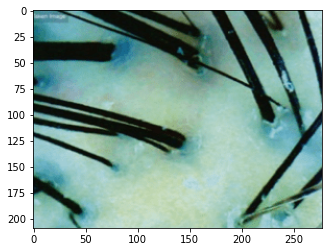

In [3]:
img = cv2.imread('./photos/scalp/image2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (250, 250))
plt.imshow(img)
print(img.shape)

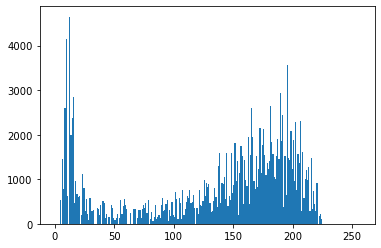

In [4]:
# # alternative way to find histogram of an image
plt.hist(img.ravel(),256,[0,256])
plt.show()

#### Final Function

In [5]:
def contrast_stretch(im, r1, s1, r2, s2):
    '''
    applies a linear transform to stretch the contrast
    im -> normalized image (0 to 1)
    r,s are transit points
    r1 mapped to s1 and r2 mapped to s2
    '''
    im = normalize(im)
    
    m = (s2-s1)/(r2-r1)
    im2 = im-r1
    im2 = im2*m
    im2 = im2 + s1
    
#     normalize
    im2 = normalize(im2)
    im2 = im2 * 255
    im2 = im2.astype('uint8')
    return im2

sun :  {(0.25, 0.1), (0.75, 1)}
dark :  {(0.08, 0.02), (0.75, 0.85)}

In [6]:
cim = contrast_stretch(img, 0.08, 0.02, 0.75, 0.85)
# cim = img.copy()

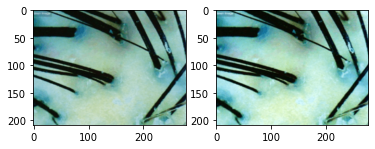

In [7]:
_, axarr = plt.subplots(1,2)

axarr[0].imshow(img)
axarr[1].imshow(cim)

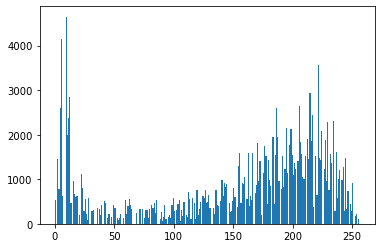

In [8]:
# # alternative way to find histogram of an image
cim_copy = cim
plt.hist(cim_copy.ravel(),256,[0,256])
plt.show()

## Bright spot removal (using mathematical morphology)

In [9]:
def bright_spot_removal(contrast_stretched_im, kernel=np.ones((2,2), np.uint8)):
#     opening = cv2.morphologyEx(contrast_stretched_im, cv2.MORPH_OPEN, kernel)
    contrast_stretched_im_copy = contrast_stretched_im.astype('float32')
    opening = cv2.cvtColor(contrast_stretched_im, cv2.COLOR_RGB2GRAY)
    mask = Preprocessing.binarize(opening, threshold=170)
    kernel2 = np.ones((2,2), np.uint8)
    opening = cv2.inpaint(contrast_stretched_im, mask.astype('uint8'), 40, cv2.INPAINT_TELEA)
    return opening


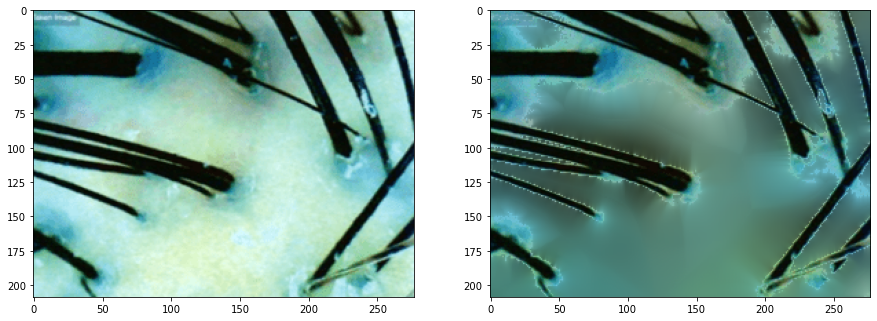

In [10]:
spot_removed = bright_spot_removal(cim)
_, axarr = plt.subplots(1,2,figsize=(15,15))

axarr[0].imshow(cim)
axarr[1].imshow(spot_removed)

## KL transform

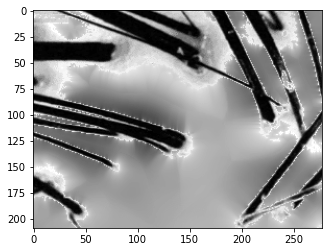

In [11]:
opening = cv2.cvtColor(spot_removed, cv2.COLOR_BGR2GRAY)
plt.imshow(opening, cmap="gray")

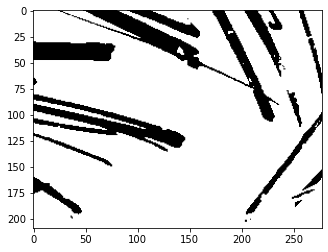

In [12]:
otsu_threshold, binary = cv2.threshold(opening, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
binary = opening.copy()
(x, y) = opening.shape
for i in range(0,x):
    for j in range(0,y):
        if opening[i][j] < otsu_threshold - 30:
            binary[i][j] = 225
        else:
            binary[i][j] = 0
            
plt.imshow(binary, cmap="binary")

In [13]:
def denoise(img):
    kernel1 = np.ones((2,2), np.uint8)
    kernel2 = np.ones((2,2), np.uint8)
#     img_erosion = cv2.erode(img, kernel1, iterations=1)
    img_final = cv2.dilate(img, kernel2, iterations=1)
    return img_final

b = denoise(binary)

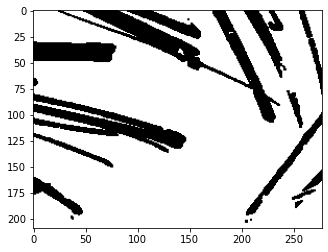

In [14]:
plt.imshow(b, cmap="binary")

## Canny Edge

In [15]:
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature

In [16]:
def canny(image):
    #image = ndi.gaussian_filter(image, 4)
    edge = feature.canny(image, sigma=0)
    return edge

In [17]:
edge = canny(binary)

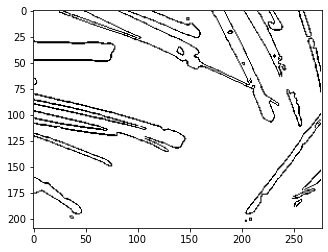

In [18]:
plt.imshow(edge, cmap="binary")

## Thinning

In [19]:
img = np.float32(binary)

In [20]:
def thin(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    # Create an empty output image to hold values
    thin = np.zeros(img.shape,dtype='uint8')
    img1 = img
    # Loop until erosion leads to an empty set
    itr = 0
    while (itr<25):
        # Erosion
        itr+=1
        erode = cv2.erode(img1,kernel)
        # Opening on eroded image
        opening = cv2.morphologyEx(erode,cv2.MORPH_OPEN,kernel)
        # Subtract these two
        subset = erode - opening
        # Union of all previous sets
        thin = cv2.bitwise_or(np.float32(subset),np.float32(thin))
        # Set the eroded image for next iteration
        img1 = erode.copy()
    return(thin)

In [21]:
thinn = thin(img)

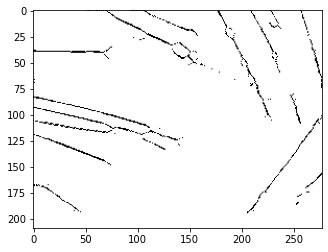

In [22]:
plt.imshow(thinn, cmap="binary")

## MSLD
1024×768  (original  scale) <br> 
512×384 <br>
256×192

#### Hough Transform

In [23]:
import random

In [24]:
# def HT(img, thresh):
#     lines = cv2.HoughLines(np.uint8(img), 1, np.pi/90, thresh)
#     print(len(lines))
#     line_im = np.ones( (img.shape[0], img.shape[1], 3) )
#     for line in lines:
#         #print(line)
#         rho,theta = line[0]
#         a = np.cos(theta)
#         b = np.sin(theta)
#         x0 = a*rho
#         y0 = b*rho
#         x1 = int(x0 + 100*(-b))
#         y1 = int(y0 + 100*(a))
#         x2 = int(x0 - 100*(-b))
#         y2 = int(y0 - 100*(a))
#         cv2.line(line_im,(x1,y1),(x2,y2),(255,0,0),3)
#     return line_im

In [25]:
# HTP
def HT(img, thresh):
    lines = cv2.HoughLinesP(img, 1, np.pi/180, thresh)
    print(len(lines))
    line_im = np.ones( (img.shape[0], img.shape[1], 3) )
    for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            cv2.line(line_im,(x1,y1),(x2,y2),(255,0,0),3)
    return line_im

In [26]:
ht = HT(thinn, 50)

error: OpenCV(4.5.2) /tmp/pip-req-build-wu1ri_rx/opencv/modules/imgproc/src/hough.cpp:471: error: (-215:Assertion failed) image.type() == CV_8UC1 in function 'HoughLinesProbabilistic'


In [ ]:
plt.imshow(ht)

#### Parallel Line Bundling

In [ ]:
plt.imshow(edge, cmap="binary")

In [ ]:
# HTP
def PLB(img, thresh):
    ms = []
    lines = cv2.HoughLinesP(np.uint8(img), 1, np.pi/180, thresh)
    print(len(lines))
    line_im = np.ones( (img.shape[0], img.shape[1], 3) )
    for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            cv2.line(line_im,(x1,y1),(x2,y2),(255,0,0),3)
            m = (y2-y1)/((x2-x1)+0.00000001)
            ms.append(m)
    return line_im, ms

In [ ]:
ht, ms = PLB(edge, 50)

In [ ]:
plt.imshow(ht)

In [ ]:
ms

## rescaling

In [ ]:
def rescale_pre(img):
    img = np.uint8(img)
    
    img1 = cv2.resize(img, (1024, 768))
    img2 = cv2.resize(img, (512, 384))
    img3 = cv2.resize(img, (256, 192))
    
    ht1 = HT(img1, 0)
    ht2 = HT(img2, 0)
    ht3 = HT(img3, 0)
    
    ht2 = cv2.resize(ht2, (1024, 768))
    ht3 = cv2.resize(ht3, (1024, 768))
    
    ht = ht1 + ht2 + ht3
    return ht

In [ ]:
ht = rescale_pre(thinn)

In [ ]:
img3 = cv2.resize(np.uint8(thinn), (256, 192))

In [ ]:
plt.imshow(img2, cmap="binary")

In [ ]:
ht2 = HT(img3, 0)

In [ ]:
plt.imshow(ht, cmap="binary")